In [1]:
# data manipulation
import pandas as pd
import numpy as np

# pre processing
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler

# model
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.neural_network import MLPClassifier

# metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# saving
import joblib

# progress monitoring
from tqdm import tqdm

In [2]:
X_train = joblib.load('../data/X_train.pkl')
y_train = joblib.load('../data/y_train.pkl')

X_train.shape, y_train.shape

((36249, 18), (36249,))

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
scoring = {
    'accuracy': 'accuracy',
    'precision_macro': make_scorer(precision_score, average='macro'),
    'recall_macro': make_scorer(recall_score, average='macro'),
    'f1_macro': make_scorer(f1_score, average='macro')
}

In [5]:
mlp = MLPClassifier(random_state=42)
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [6]:
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],  
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'learning_rate_init': [0.001, 0.01, 0.1]
}

In [7]:
pipeline_param_grid = {
    'mlp__hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],  
    'mlp__activation': ['relu', 'tanh', 'logistic'],
    'mlp__solver': ['adam', 'sgd'],
    'mlp__alpha': [0.0001, 0.001, 0.01],
    'mlp__learning_rate': ['constant', 'invscaling', 'adaptive'],
    'mlp__learning_rate_init': [0.001, 0.01, 0.1]
}

In [8]:
def train_random_search(X, y, estimator, grid, n_iter=20):
    random_search = RandomizedSearchCV(
        estimator=estimator,
        param_distributions=grid,
        cv=skf,
        scoring=scoring,
        refit='f1_macro',
        n_jobs=-1,
        return_train_score=True,
        verbose=0,
        n_iter=n_iter
    )

    
    with tqdm(total=n_iter, desc="RandomizedSeachCV Progress") as pbar:
        random_search.fit(X, y)
        pbar.update(n_iter)

    return random_search

In [10]:
def get_results(r_search, pipeline=False):
    results = pd.DataFrame(r_search.cv_results_)
    
    if pipeline:
        results = results[
            [
                'mean_fit_time', 'mean_score_time', 'param_mlp__hidden_layer_sizes', 'param_mlp__activation', 'param_mlp__solver',
                'param_mlp__alpha', 'param_mlp__learning_rate', 'param_mlp__learning_rate_init', 'mean_train_accuracy', 
                'mean_test_accuracy', 'rank_test_accuracy', 
                'mean_train_precision_macro', 'mean_test_precision_macro', 'rank_test_precision_macro', 'mean_train_recall_macro', 
                'mean_test_recall_macro', 'rank_test_recall_macro', 'mean_train_f1_macro', 'mean_test_f1_macro', 'rank_test_f1_macro'
            ]
        ]
    else:
        results = results[
            [
                'mean_fit_time', 'mean_score_time', 'param_hidden_layer_sizes', 'param_activation', 'param_solver',
                'param_alpha', 'param_learning_rate', 'param_learning_rate_init', 'mean_train_accuracy', 
                'mean_test_accuracy', 'rank_test_accuracy', 
                'mean_train_precision_macro', 'mean_test_precision_macro', 'rank_test_precision_macro', 'mean_train_recall_macro', 
                'mean_test_recall_macro', 'rank_test_recall_macro', 'mean_train_f1_macro', 'mean_test_f1_macro', 'rank_test_f1_macro'
            ]
        ]


    results = results.sort_values(by='mean_test_f1_macro', ascending=False)
    return results

In [11]:
rs = train_random_search(X_train, y_train, mlp, param_grid, 20)

RandomizedSeachCV Progress: 100%|██████████| 20/20 [08:30<00:00, 25.50s/it]


In [12]:
results = get_results(rs)
results.head()

,mean_fit_time,mean_score_time,param_hidden_layer_sizes,param_activation,param_solver,param_alpha,param_learning_rate,param_learning_rate_init,mean_train_accuracy,mean_test_accuracy,rank_test_accuracy,mean_train_precision_macro,mean_test_precision_macro,rank_test_precision_macro,mean_train_recall_macro,mean_test_recall_macro,rank_test_recall_macro,mean_train_f1_macro,mean_test_f1_macro,rank_test_f1_macro
1,71.435713,0.048361,"(100, 50)",tanh,adam,0.0001,adaptive,0.01,0.924363,0.905735,1,0.924317,0.905287,1,0.920867,0.901592,1,0.922290,0.903103,1
18,92.775987,0.043490,"(100, 50)",tanh,adam,0.01,adaptive,0.001,0.906741,0.901101,2,0.905006,0.899179,2,0.904613,0.898850,2,0.904542,0.898763,2
8,39.258279,0.035527,"(100,)",tanh,adam,0.001,constant,0.01,0.897910,0.893818,3,0.897126,0.893160,3,0.894114,0.889752,3,0.895176,0.890920,3
10,29.344705,0.030270,"(50,)",relu,adam,0.001,constant,0.001,0.894176,0.891887,4,0.891829,0.889648,4,0.891984,0.889549,4,0.891752,0.889366,4
6,6.092168,0.026686,"(100,)",relu,adam,0.001,constant,0.1,0.876046,0.876604,5,0.874922,0.875225,5,0.872203,0.872829,5,0.872736,0.873343,5


In [13]:
def view_test_metrics(train_metrics: bool, filter_top_n: int, results_df: pd.DataFrame, pipeline: bool=False):
    if train_metrics:
        metrics = [
            "mean_train_accuracy", "mean_test_accuracy",
            "mean_train_precision_macro", "mean_test_precision_macro",
            "mean_train_recall_macro", "mean_test_recall_macro",
            "mean_train_f1_macro", "mean_test_f1_macro"
        ]
    else:
        metrics = [
            "mean_test_accuracy",
            "mean_test_precision_macro",
            "mean_test_recall_macro",
            "mean_test_f1_macro"
        ]

    if filter_top_n:
        results_df = results_df.nsmallest(filter_top_n, "rank_test_f1_macro")

    if pipeline:
        param_cols = [
        'param_mlp__hidden_layer_sizes', 'param_mlp__activation', 'param_mlp__solver',
        'param_mlp__alpha', 'param_mlp__learning_rate', 'param_mlp__learning_rate_init'
    ]
    else:
        param_cols = [
        'param_hidden_layer_sizes', 'param_activation', 'param_solver',
        'param_alpha', 'param_learning_rate', 'param_learning_rate_init'
    ]


    plot_df = results_df.melt(
        id_vars=param_cols,      # keep these columns "as is"
        value_vars=metrics,      # the columns we want to "unpivot"
        var_name="metric",       # new column with the metric name
        value_name="score"       # new column with the metric value
    )

    plt.figure(figsize=(8, 8))
    
    # Group the data by parameter combination and create a list of groups.
    groups = list(plot_df.groupby(param_cols))
    # Create a color palette with as many colors as there are groups.
    colors = plt.cm.tab10(np.linspace(0, 1, len(groups)))
    
    for i, (combo, group) in enumerate(groups):
        group = group.sort_values("metric")
        # Create a label for the model using its parameters.
        label_str = ", ".join(f"{col}={val}" for col, val in zip(param_cols, combo))
        # Pick the color for this group.
        color = colors[i]
        
        # Separate training and test metrics
        train_group = group[group["metric"].str.startswith("mean_train")]
        test_group = group[~group["metric"].str.startswith("mean_train")]
        
        # Plot training metrics with the same color
        if not train_group.empty:
            plt.plot(train_group["metric"], train_group["score"], 
                     marker='x', linestyle='dashed', alpha=0.7,
                     color=color,
                     label=label_str + " (train)")
        # Plot test metrics with the same color
        if not test_group.empty:
            plt.plot(test_group["metric"], test_group["score"], 
                     marker='o', linestyle='solid', alpha=0.7,
                     color=color,
                     label=label_str + " (test)")

    plt.xlabel("Metric")
    plt.ylabel("Score")
    plt.title("Comparison of Mean Test Metrics")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

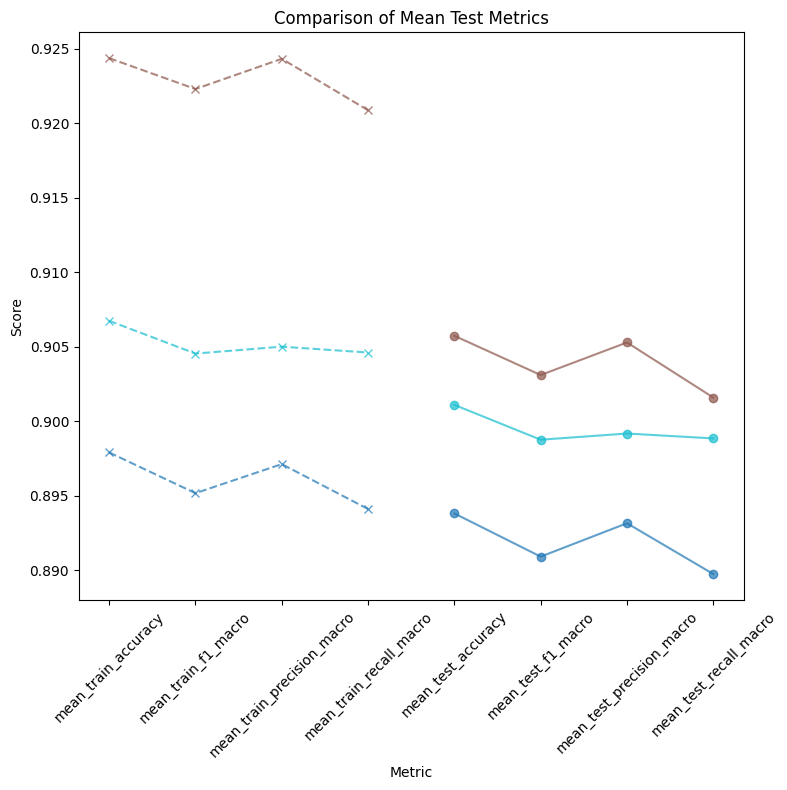

In [14]:
view_test_metrics(True, 3, results)

In [15]:
col_names = joblib.load('../data/cols.pkl')

C:\Users\caiop\AppData\Local\Temp\ipykernel_31500\984357541.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Importance', y='Feature', data=importance_df, palette='Blues_d')


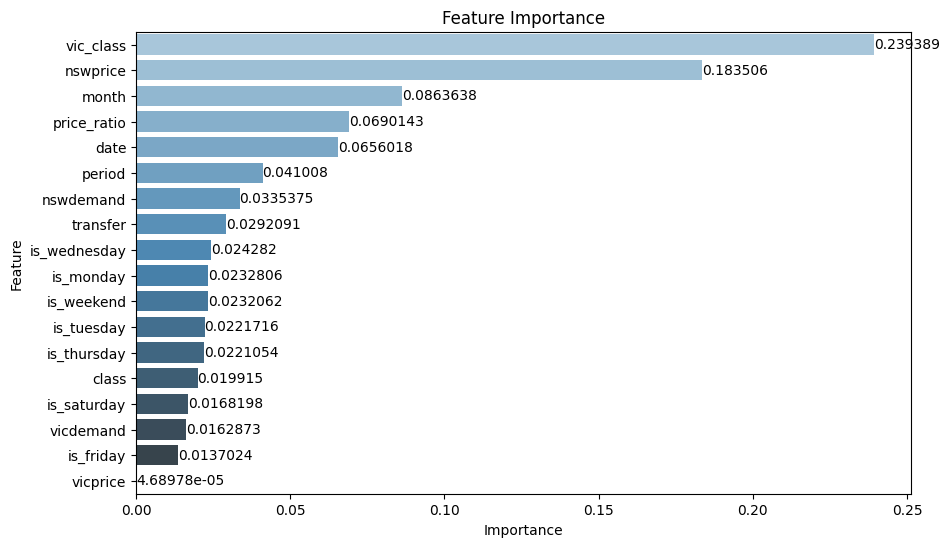

In [16]:
from sklearn.inspection import permutation_importance

def feature_importance(model):
    result = permutation_importance(
    estimator=model,       
    X=X_train,
    y=y_train,
    n_repeats=10,
    random_state=42
)

    importances = result.importances_mean
    importance_df = pd.DataFrame({
        'Feature': col_names[:-1],
        'Importance': importances
    })

    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='Importance', y='Feature', data=importance_df, palette='Blues_d')
    for container in ax.containers:
        ax.bar_label(container)
    plt.title('Feature Importance')
    plt.show()
feature_importance(rs.best_estimator_)

## Testando balanceamento

In [17]:
ro_pipeline = Pipeline([
    ('oversampler', RandomOverSampler(sampling_strategy='auto', random_state=42)),
    ('mlp', MLPClassifier(random_state=42))
])

In [18]:
ro_rs = train_random_search(X_train, y_train, ro_pipeline, pipeline_param_grid, 20)

RandomizedSeachCV Progress: 100%|██████████| 20/20 [07:18<00:00, 21.94s/it]


In [19]:
ro_results = get_results(ro_rs, True)
ro_results.head()

,mean_fit_time,mean_score_time,param_mlp__hidden_layer_sizes,param_mlp__activation,param_mlp__solver,param_mlp__alpha,param_mlp__learning_rate,param_mlp__learning_rate_init,mean_train_accuracy,mean_test_accuracy,rank_test_accuracy,mean_train_precision_macro,mean_test_precision_macro,rank_test_precision_macro,mean_train_recall_macro,mean_test_recall_macro,rank_test_recall_macro,mean_train_f1_macro,mean_test_f1_macro,rank_test_f1_macro
11,61.584436,0.042699,"(100, 50)",tanh,adam,0.001,constant,0.01,0.920924,0.903997,1,0.918601,0.901657,1,0.921700,0.904155,1,0.919450,0.902169,1
19,46.544667,0.016714,"(100, 50)",relu,adam,0.0001,invscaling,0.01,0.916231,0.902563,2,0.913459,0.899477,2,0.917338,0.903513,2,0.914756,0.900863,2
14,19.611183,0.023264,"(50, 50)",relu,adam,0.01,adaptive,0.01,0.897591,0.890783,3,0.894705,0.887766,3,0.898966,0.891991,3,0.895895,0.888970,3
17,29.516450,0.023353,"(50,)",relu,sgd,0.01,adaptive,0.1,0.892849,0.889735,4,0.889265,0.886142,4,0.894251,0.891080,4,0.891127,0.887962,4
3,30.121106,0.022171,"(50,)",relu,adam,0.001,constant,0.001,0.891090,0.889045,5,0.887606,0.885498,5,0.892552,0.890566,6,0.889352,0.887292,5


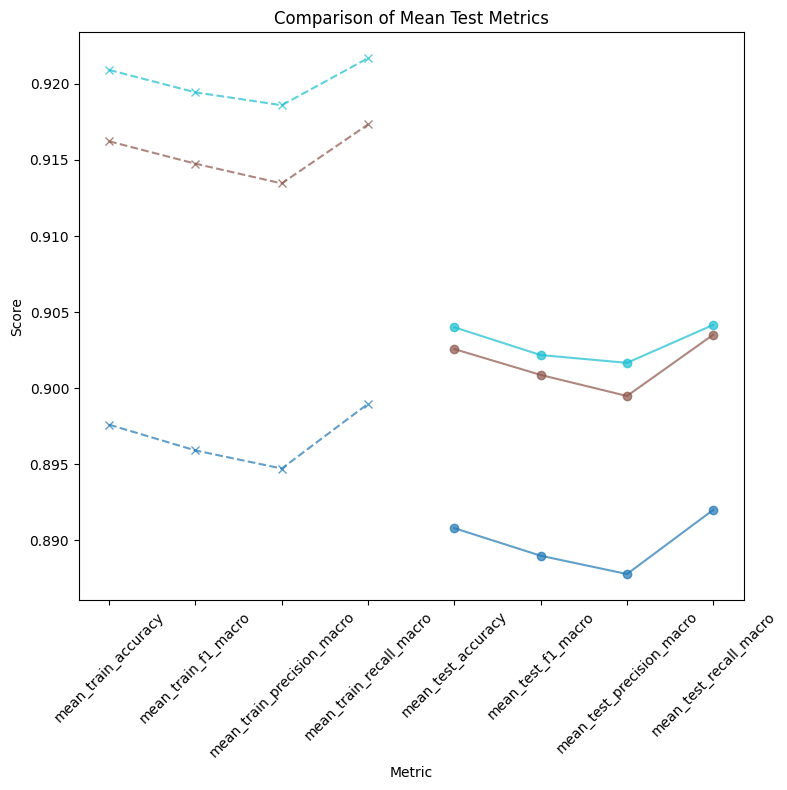

In [20]:
view_test_metrics(True, 3, ro_results, True)

C:\Users\caiop\AppData\Local\Temp\ipykernel_31500\984357541.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Importance', y='Feature', data=importance_df, palette='Blues_d')


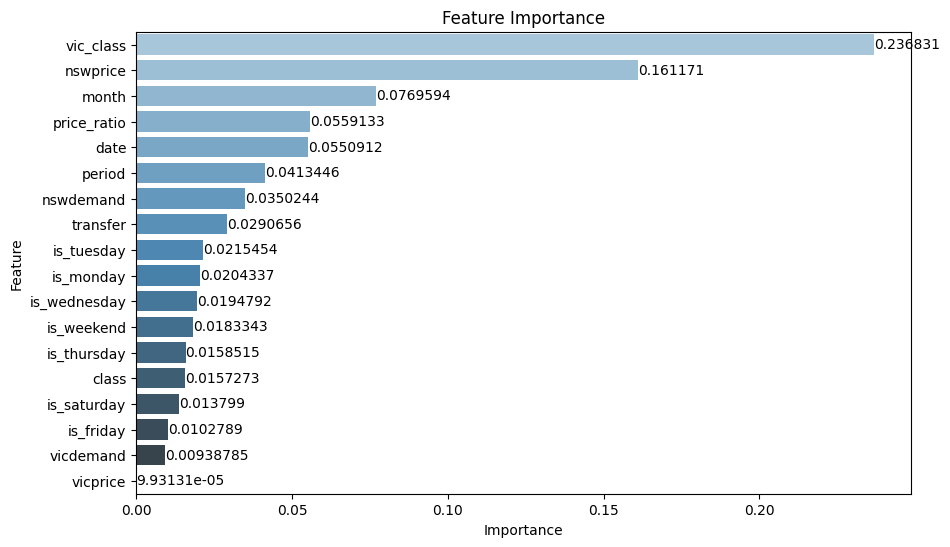

In [21]:
feature_importance(ro_rs.best_estimator_.named_steps['mlp'])

In [22]:
preds = cross_val_predict(rs.best_estimator_, X_train, y_train, cv=skf, n_jobs=-1)

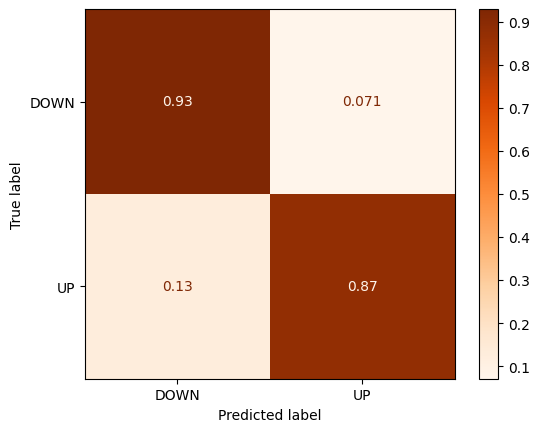

In [23]:
cm = confusion_matrix(y_train, preds, normalize='true')
cmd = ConfusionMatrixDisplay(cm, display_labels=['DOWN', 'UP'])
cmd.plot(cmap=plt.cm.Oranges)
plt.grid(False)
plt.show()

In [24]:
print(classification_report(y_train, preds, digits=4))

              precision    recall  f1-score   support

           0     0.9091    0.9291    0.9190     20860
           1     0.9009    0.8741    0.8873     15389

    accuracy                         0.9057     36249
   macro avg     0.9050    0.9016    0.9031     36249
weighted avg     0.9056    0.9057    0.9055     36249



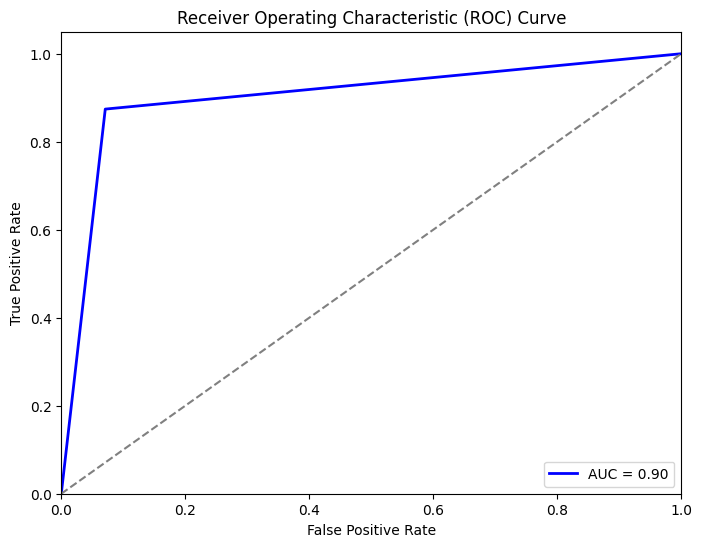

In [25]:
fpr, tpr, thresholds = roc_curve(y_train, preds)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random classifier)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [26]:
joblib.dump(rs.best_estimator_, '../models/mlp.pkl')

['../models/mlp.pkl']